## Feature selection within linear models

### Problem

You want to predict $y \in \mathbb{R}$ using linear regression. 

You got too many $x \in \mathbb{R}^{m}$ features to do so, and most of them are probably not statistically signifiant at all. 

You want to select the best features ($x$ coordinates) to perform the prediction. 

### Implemented solution

In this notebook, we implement some techniques to solve this problem. 

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import OLS
from copy import deepcopy

## 1. Generate data

We generate a matrix $X$ of $n=400$ observations of normaly distributed data, with $m=80$ features for each datapoint. 

We then generate a random feature vector $b \in \mathbb{R^{m'}}$, with $m'=10$.

We set the dependent variable $y = a + < X', b>$, where $a \in \mathbb{R}$ and $X'$ is a matrix with only the 10 first columns of $X$. This means that the $y$ is perfectly linearly dependent of the 10 first columns of $X$ *only*. The other columns of $X$ are just noise or irrelevant data. 

Finally, we add some gaussian noise to $y$.

In [130]:
n = 400
m = 80 

X = np.random.normal(size=(n, m))

a = 10 # intercept
b = 10*np.random.normal(size=10)
y = a + X[:,:10].dot(b) 
y = y + np.random.normal(size=n)*0.1

For example, this is a feature from which $y$ depends *a lot*.

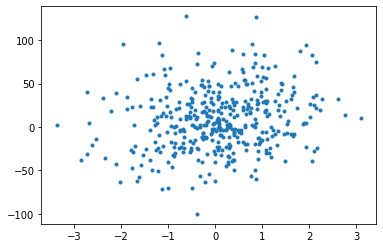

In [131]:
plt.plot(X[:, np.argmax(b)], y, '.')

And this is a feature from which $y$ does not depend at all. 

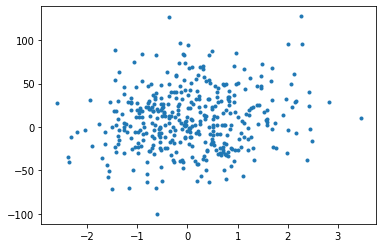

In [132]:
plt.plot(X[:,-1], y, '.')

## 2. p-value cutoff

Let's run a quick OLS on all the features. 

In [137]:
def add_1(X):
    n = X.shape[0]
    i = np.ones((n,1))
    return np.concatenate((i, X), axis=1)

def run_OLS(X, y, const=True):
    """Performs an OLS regression using the module statsmodel."""
    if const:
        model = OLS(y, add_1(X), hasconst=True).fit()
    else:
        model = OLS(y, X).fit()
    return model

model = run_OLS(X_train, y_train)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.400e+05
Date:                Sat, 11 Jan 2020   Prob (F-statistic):               0.00
Time:                        18:29:52   Log-Likelihood:                 306.71
No. Observations:                 320   AIC:                            -451.4
Df Residuals:                     239   BIC:                            -146.2
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.0037      0.007   1425.095      0.000       9.990      10.018
x1            -8.1817      0.007  -1163.353      0.000      -8.196      -8.168
x2            -6.6606      0.007   -927.637      0.000      -6.675      -6.646
x3             3.5169      0.007    483.256      0.000       3.503       3.531
x4           -19.3074      0.007  -2841.285      0.000     -19.321     -19.294
x5            -6.0600      0.007   -861.274      0.000      -6.074      -6.046
x6           -11.8917      0.007  -1762.212      0.000     -11.905     -11.878
x7           -14.2903      0.007  -2039.718      0.000     -14.304     -14.277
x8            -0.5231      0.007    -79.275      0.000      -0.536      -0.510
x9           -12.9008      0.007  -1780.168      0.000     -12.915     -12.887
x10            7.2120      0.006   1173.182      0.000       7.200       7.224
x11            0.0021      0.007      0.291      0.771      -0.012       0.016
x12            0.0006      0.007      0.088      0.930      -0.012       0.013
x13           -0.0044      0.006     -0.682      0.496      -0.017       0.008
x14            0.0052      0.007      0.798      0.426      -0.008       0.018
x15           -0.0025      0.007     -0.347      0.729      -0.016       0.011
x16           -0.0010      0.007     -0.144      0.886      -0.014       0.012
x17            0.0037      0.007      0.520      0.604      -0.010       0.018
x18           -0.0004      0.007     -0.053      0.958      -0.014       0.013
x19            0.0075      0.007      1.127      0.261      -0.006       0.021
x20            0.0085      0.007      1.220      0.224      -0.005       0.022
x21            0.0063      0.007      0.900      0.369      -0.007       0.020
x22            0.0018      0.007      0.262      0.794      -0.012       0.016
x23            0.0013      0.006      0.212      0.832      -0.011       0.014
x24            0.0012      0.006      0.179      0.858      -0.012       0.014
x25            0.0014      0.006      0.220      0.826      -0.011       0.014
x26           -0.0084      0.007     -1.212      0.227      -0.022       0.005
x27            0.0005      0.007      0.070      0.944      -0.014       0.015
x28            0.0041      0.007      0.558      0.577      -0.010       0.019
x29            0.0025      0.007      0.376      0.707      -0.011       0.016
x30            0.0061      0.007      0.889      0.375      -0.007       0.020
x31           -0.0022      0.007     -0.308      0.758      -0.016       0.012
x32            0.0002      0.008      0.027      0.978      -0.015       0.015
x33            0.0010      0.007      0.153      0.879      -0.012       0.014
x34           -0.0014      0.007     -0.203      0.839      -0.015       0.012
x35           -0.0045      0.007     -0.635      0.526      -0.018       0.009
x3

Now do a hard cutoff on the coefficients p-values (ex : 1%). Those are the selected coefficients. 

In [148]:
selected_variables = np.array(list(range(m+1)))[model.pvalues < 0.01]

selected_variables

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

This simple approach is surprisingly effective, as it as found every pertinent feature.

## 2. Forward selection algorithm

In [152]:
def forward_selection(X, y, eps=0.1, wordy=True):
    """Forward selection method for linear regression.
    Returns a list of indexes for features of X."""
    n = X.shape[0]
    p = X.shape[1]
    stop = False
    selected_var = []
    residual_y = deepcopy(y)
    indexes_left = list(range(p))
    p_values_stored = []
    iterator = 0
    while stop is False:
        T_stats = []
        p_values = []
        # Compute test statistics for each variable left
        for k in indexes_left:
            X_k = X[:,k].reshape(-1,1)
            model = run_OLS(X_k, residual_y, const=False)
            T = np.abs(model.tvalues[0])
            p_value = model.pvalues[0]
            T_stats.append(T)
            p_values.append(p_value)
        # Stopping criterion 
        if indexes_left==[] or min(p_values) > eps: 
            stop = True
        else:     
            # Find best var index 
            best_k_i = np.argmax(T_stats)
            best_k = indexes_left[best_k_i]
            # Add it to a list
            selected_var.append(best_k)
            indexes_left.remove(best_k)
            # Compute the linear regression model and...
            X_k = X[:,best_k].reshape(-1, 1)
            model = run_OLS(X_k, residual_y, const=False)
            # ... Recompute the residual
            residual_y -= model.predict(X_k)
        iterator += 1
            
    return selected_var
    
features_selected = forward_selection(X, y, 0.01)

features_selected

[3, 6, 5, 8, 9, 0, 4, 1, 2]

## 3. Lasso

In [156]:
from sklearn.linear_model import LassoCV
lasso_reg = LassoCV(cv=5)

lasso_reg.fit(X, y)

features_selected = np.array(range(len(lasso_reg.coef_)))[lasso_reg.coef_ != 0]

features_selected

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])